In [29]:
import numpy as np 
import pandas as pd 
import os

In [30]:
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [31]:
main_dir = "Vehicles"
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

In [32]:
split_dirs = ["train", "val", "test"]
base_split_dir = "vehicles_split"

for split_dir in split_dirs:
    for category in categories:
        os.makedirs(os.path.join(base_split_dir, split_dir, category), exist_ok=True)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,           # Xoay ảnh ngẫu nhiên trong khoảng 40 độ
    width_shift_range=0.2,       # Dịch ngang ngẫu nhiên trong khoảng 20%
    height_shift_range=0.2,      # Dịch dọc ngẫu nhiên trong khoảng 20%
    shear_range=0.2,             # Biến dạng hình ảnh
    zoom_range=0.2,              # Phóng to hoặc thu nhỏ ngẫu nhiên
    horizontal_flip=True,        # Lật ngang ngẫu nhiên
    vertical_flip=True,          # Lật dọc ngẫu nhiên
    brightness_range=[0.8, 1.2], # Điều chỉnh độ sáng ngẫu nhiên từ 80% đến 120%
    fill_mode='nearest'          # Cách lấp đầy pixel khi xoay/dịch ảnh
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    os.path.join(base_split_dir, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_split_dir, "val"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_split_dir, "test"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 3911 images belonging to 7 classes.
Found 838 images belonging to 7 classes.
Found 838 images belonging to 7 classes.


In [35]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 20/123 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - accuracy: 0.3620 - loss: 2.1522

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


123/123 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.6042 - loss: 1.2382 - val_accuracy: 0.9021 - val_loss: 0.2931
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 102s 816ms/step - accuracy: 0.8340 - loss: 0.4946 - val_accuracy: 0.8998 - val_loss: 0.2881
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 103s 824ms/step - accuracy: 0.8460 - loss: 0.4389 - val_accuracy: 0.9141 - val_loss: 0.2467
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 102s 816ms/step - accuracy: 0.8573 - loss: 0.3972 - val_accuracy: 0.9141 - val_loss: 0.2594
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 115s 922ms/step - accuracy: 0.8673 - loss: 0.3735 - val_accuracy: 0.9224 - val_loss: 0.2427
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 111s 892ms/step - accuracy: 0.8928 - loss: 0.3225 - val_accuracy: 0.9200 - val_loss: 0.2162
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8681 - loss: 0.3602 - val_accuracy: 0.9081 - val_loss: 0.2647
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 102s 816ms/step - accuracy: 0.8645 - loss: 0.3620 - v

In [37]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 727ms/step - accuracy: 0.9395 - loss: 0.2004
Test accuracy: 93.68%


In [40]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
history_fine = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
 55/123 ━━━━━━━━━━━━━━━━━━━━ 5:39 5s/step - accuracy: 0.9056 - loss: 0.2768

KeyboardInterrupt: 

In [42]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%") 

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 625ms/step - accuracy: 0.9510 - loss: 0.1663
Test accuracy: 94.99%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


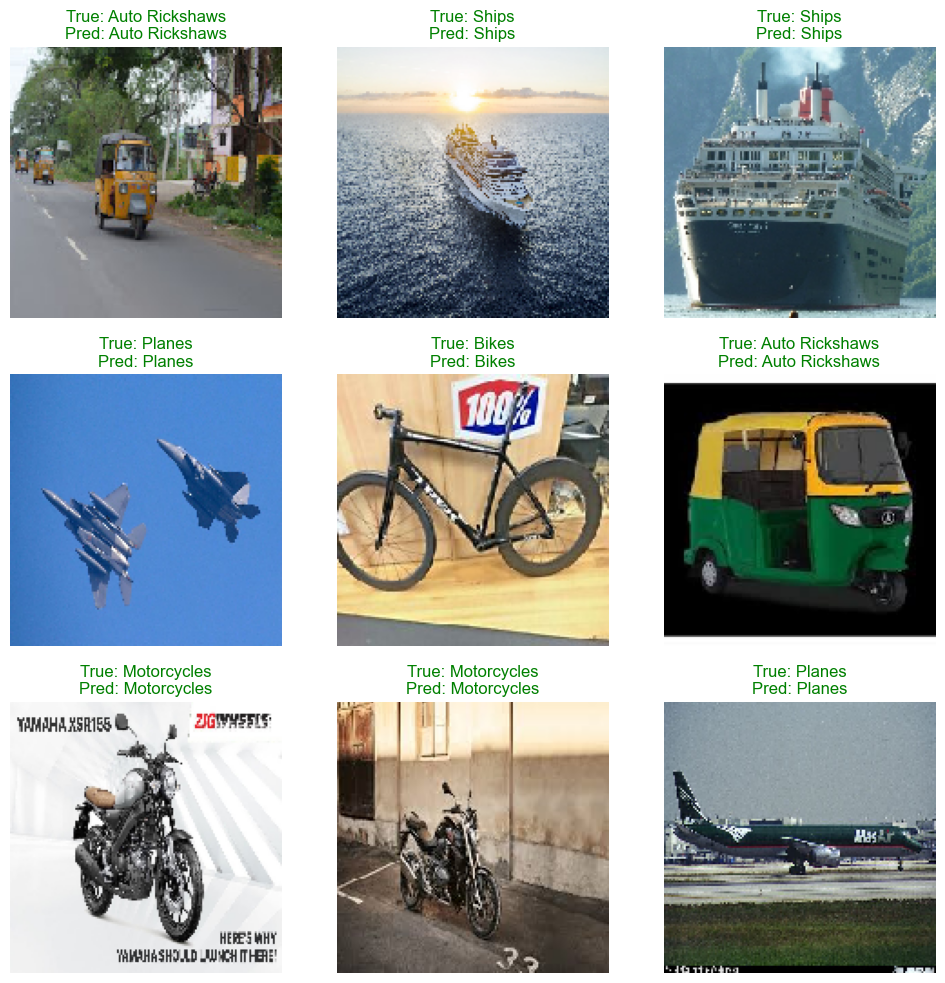

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Lấy một lô hình ảnh và nhãn từ test_generator
test_images, test_labels = next(test_generator)
indices = random.sample(range(len(test_images)), 9)

# Dự đoán cho các hình ảnh được chọn
predictions = model.predict(test_images[indices])
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels[indices], axis=1)

# Vẽ hình ảnh cùng với nhãn dự đoán và nhãn thực tế
plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])  # Kiểm tra định dạng của test_images
    plt.axis('off')

    true_label = categories[true_labels[i]]
    predicted_label = categories[predicted_labels[i]]
    color = 'green' if true_label == predicted_label else 'red'

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()


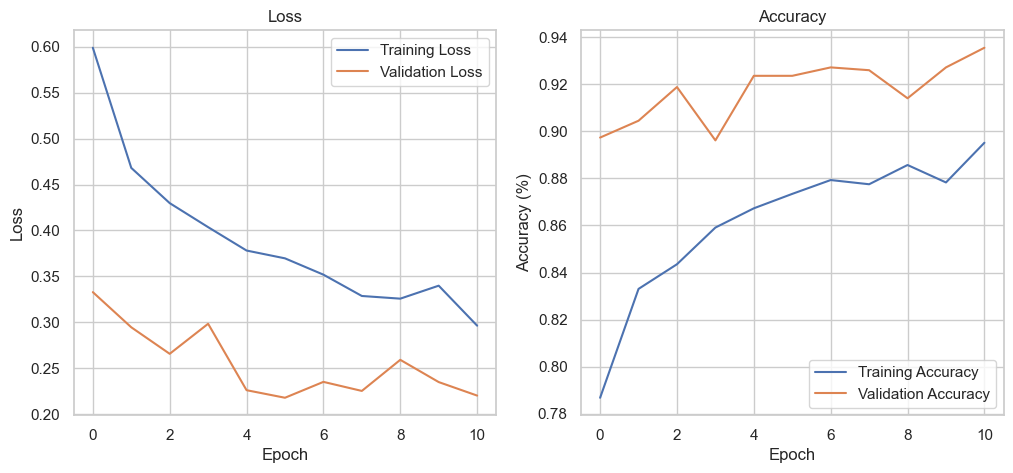

In [28]:
import matplotlib.pyplot as plt

# Lấy các giá trị về độ chính xác và lỗi từ lịch sử
history_dict = history.history

# Vẽ biểu đồ độ lỗi
plt.figure(figsize=(12, 5))

# Subplot cho Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot cho Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


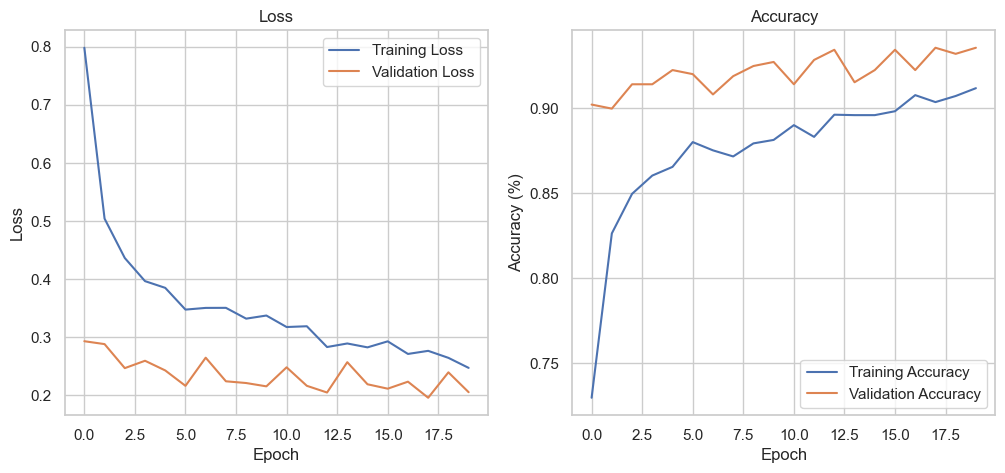

In [44]:
import matplotlib.pyplot as plt

# Truy cập lịch sử huấn luyện
history_dict = history.history

# Vẽ biểu đồ độ lỗi
plt.figure(figsize=(12, 5))

# Subplot cho Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot cho Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()
